In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from collections import Counter

Load data

In [2]:
data = np.load('/flatland_train.npz')
X = data['X']
y = data['y']

Let's check the shape

In [ ]:
X.shape

(10000, 50, 50)

In [ ]:
y.shape

(10000,)

Change the numeration

In [3]:
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255.      # Scale down to range [0, 1]

Let's use the counter command

In [6]:
Counter(y)

Counter({2.0: 1868, 4.0: 1761, 3.0: 2137, 1.0: 2853, 0.0: 1381})

We can see that a Hexagon is the figure that has the most corners in here.

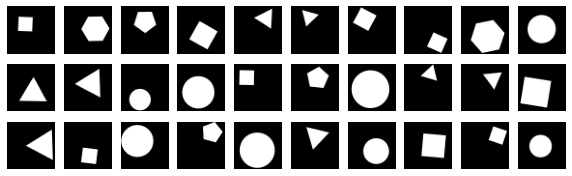

In [5]:
plt.figure(figsize=(10, 3)) #plot of first 30 figures
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
plt.show()

Let's split data to training and testing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

We add additional data that is just a mirror view of existing ones.

In [8]:
X_train_aug = np.concatenate([X_train, X_train[..., ::-1]])
y_train_aug = np.concatenate([y_train, y_train])

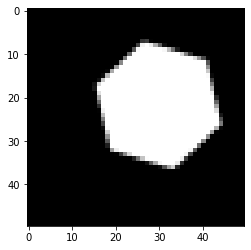

In [9]:
plt.imshow(X_train[5], cmap='gray')

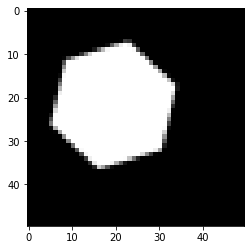

In [10]:
plt.imshow(X_train[5][..., ::-1], cmap='gray')

In [11]:
Counter(y_train)

Counter({3.0: 1617, 1.0: 2147, 0.0: 1002, 4.0: 1340, 2.0: 1394})

In [12]:
Counter(y_test)

Counter({1.0: 706, 0.0: 379, 4.0: 421, 3.0: 520, 2.0: 474})

(array([1381.,    0., 2853.,    0.,    0., 1868.,    0., 2137.,    0.,
        1761.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

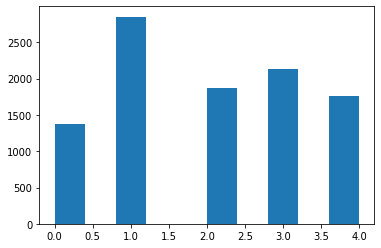

In [13]:
plt.hist(y)

Data y appears to have not normal distribution.

(array([0.34525, 0.     , 0.71325, 0.     , 0.     , 0.467  , 0.     ,
        0.53425, 0.     , 0.44025]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

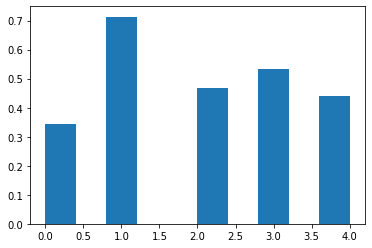

In [14]:
plt.hist(y, density=1)

In [15]:
X_train.shape

(7500, 50, 50)

In [16]:
X_train_aug.shape

(15000, 50, 50)

We will use augmented data,

In our NN: 

*   we have only 2 hidden layers because the data appears to be not very complicated;
*   I found layers size to be optimal at 512, and 256, other number tends prolong the calculations with no visible improvement;
*   Optimizer Adam - this by far the best;
*   Batch size is bigger than default(32), results similar, but much more faster calculations;
*   Drop out I found to have best results when they are set to 0.2;
*   Relu hands down the best activation.












Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50)]          0         
                                                                 
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense (Dense)               (None, 512)               1280512   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1285  

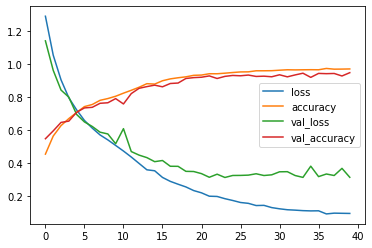

In [17]:
inp = keras.layers.Input(shape=(50, 50))
out = keras.layers.Flatten()(inp)
out = keras.layers.Dense(512,  activation='relu')(out)
out = keras.layers.Dropout(0.2)(out)
out = keras.layers.Dense(256,  activation='relu')(out)
out = keras.layers.Dropout(0.2)(out)
out = keras.layers.Dense(5,  activation='softmax')(out)


model = keras.models.Model(inputs=inp, outputs=out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

from datetime import datetime

hist = model.fit(X_train_aug, y_train_aug,
                validation_data=(X_test, y_test),
                 epochs=40, batch_size=128)

pd.DataFrame(hist.history).plot()

Now let's see the results

79/79 [==============================] - 0s 2ms/step


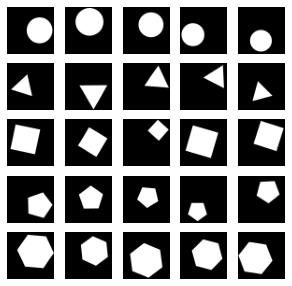

In [18]:
pred = model.predict(X_test).argmax(axis=1)

plt.figure(figsize=(5, 5))
for label in range(5):
    for i in range(5):
        plt.subplot(5, 5, label * 5 + i +1)
        plt.imshow(X_test[pred == label][i], cmap='gray')
        plt.axis('off')
plt.show()

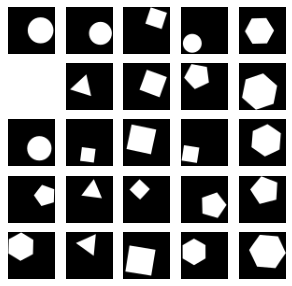

In [19]:
plt.figure(figsize=(5, 5))
for label in range(5):
    for i in range(5):
        plt.subplot(5, 5, label * 5 + i + 1)
        mask = (pred == i) & (y_test == label)
        if mask.sum() > 0:
            plt.imshow(X_test[mask][0], cmap='gray')
        plt.axis('off')
plt.show()

issaugoti modeli, atsisiusti notebooka, 

In [20]:
model.save('model.h5')